In [8]:
%load_ext autoreload
%autoreload 2
import os 
os.chdir("/home/adnane/Desktop/satellite-yasser-run/Satellite_Super_Resulotion0")

import torch 
from torch import nn
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import csv

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Models
from src.utils.models_architecture import GENERATOR


# functions 
from src.utils.helper_functions import calculate_psnr, initialize_weights

# dataloader
from src.utils.data_loader import create_loaders_for_ESRGAN

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# DATA LOADERS

In [9]:
root = "data/preprocessed"
BATCH_SIZE = 32
NUM_WORKERS = 6

train_loader, val_loader, test_loader = create_loaders_for_ESRGAN(root, BATCH_SIZE, NUM_WORKERS)

lr, hr = next(iter(train_loader))
print(len(train_loader))
print("lr.shape : ", lr.shape)
print("hr.shape : ", hr.shape)


 DATA LOADED:
  Train: 152352 samples
  Val:   19044 samples
  Test:  19044 samples
4761
lr.shape :  torch.Size([32, 3, 32, 32])
hr.shape :  torch.Size([32, 3, 128, 128])


# SAMPLES VISUALISATION

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7411765..0.8509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8352941..0.6862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.60784316..0.27843142].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7647059..-0.027450979].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6862745..0.45882356].


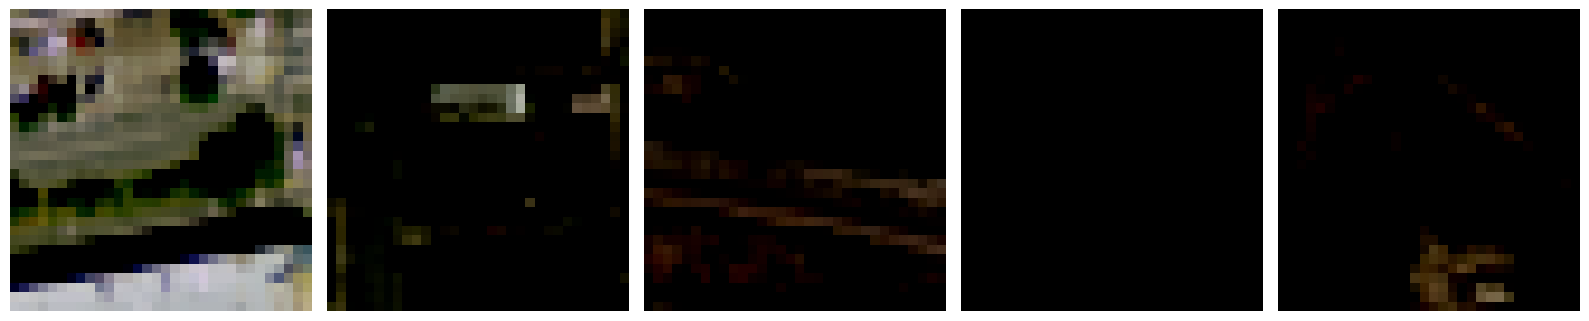

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8509804..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8666667..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.64705884..0.4901961].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.88235295..0.30196083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7254902..0.6784314].


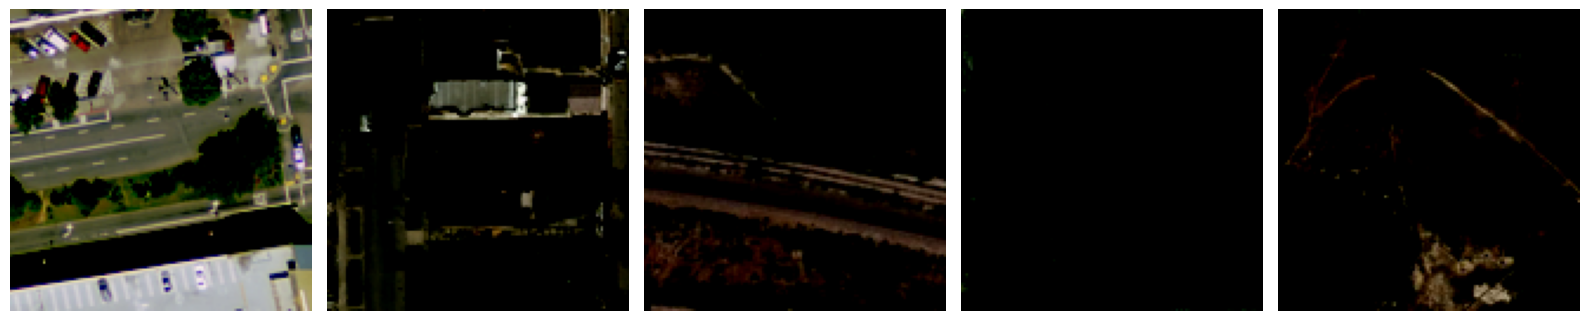

In [10]:
lr, hr = next(iter(train_loader))

# PLOTING LOWER RES IMAGES
plt.figure(figsize=(16, 5))
rows, cols = 1, 5
for i in range(rows * cols):
    img = lr[i]
    plt.subplot(rows, cols, i+1)
    plt.imshow(img.permute(1, 2, 0))
    plt.axis("off")
plt.tight_layout()
plt.show()


# PLOTING HIGHIER RES IMAGES
plt.figure(figsize=(16, 5))
rows, cols = 1, 5
for i in range(rows * cols):
    img = hr[i]
    plt.subplot(rows, cols, i+1)
    plt.imshow(img.permute(1, 2, 0))
    plt.axis("off")
plt.tight_layout()
plt.show()

# Stage 1: MAXIMAZING PSNR

In [11]:
generator = GENERATOR(3, 64, 18).to(device)
generator.apply(initialize_weights)
loss_fn = torch.nn.L1Loss()
optimiser = torch.optim.Adam(generator.parameters(), lr=2e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimiser,
    mode='max',       # maximize PSNR
    factor=0.5,       # LR reduced by half when plateau
    patience=3,       # wait 3 epochs
    min_lr=1e-6,
    verbose=True
)

/home/adnane/miniconda3/envs/torch/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# HANDLING CHECKPOINTS: LOAD & SAVE

In [9]:
def save_latest(generator, optimiser, scheduler, epoch, base_dir):
    torch.save(generator.state_dict(), os.path.join(base_dir, "latest_gen.pth"))
    torch.save(optimiser.state_dict(), os.path.join(base_dir, "latest_optim.pth"))
    torch.save(scheduler.state_dict(), os.path.join(base_dir, "latest_sched.pth"))
    torch.save(epoch, os.path.join(base_dir, "latest_epoch.pth"))

def save_best(generator, base_dir):
    torch.save(generator.state_dict(), os.path.join(base_dir, "best_gen.pth"))

def load_latest(generator, optimiser, scheduler, base_dir):
    gen_p = os.path.join(base_dir, "latest_gen.pth")
    if os.path.exists(gen_p):
        generator.load_state_dict(torch.load(gen_p))
        optimiser.load_state_dict(torch.load(os.path.join(base_dir, "latest_optim.pth")))
        scheduler.load_state_dict(torch.load(os.path.join(base_dir, "latest_sched.pth")))
        start_epoch = torch.load(os.path.join(base_dir, "latest_epoch.pth")) + 1
        print(f"Resuming from epoch {start_epoch}")
        return start_epoch
    return 0

# Training Function

In [ ]:
def train_stage_1(generator, train_loader, val_loader,
                  optimiser, scheduler, loss_fn,
                  epochs, device):

    base_dir = "./checkpoint-ESRGAN/stage-1"
    os.makedirs(base_dir, exist_ok=True)

    start_epoch = load_latest(generator, optimiser, scheduler, base_dir)

    csv_path = os.path.join(base_dir, "stage1_metrics.csv")

    # ---------- Create CSV header ----------
    if not os.path.exists(csv_path):
        with open(csv_path, mode="w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([
                "epoch",
                "train_loss",
                "train_psnr",
                "val_loss",
                "val_psnr"
            ])

    best_psnr = 0.0

    for epoch in range(start_epoch, epochs):

        # ---------- Training ----------
        generator.train()
        train_loss_sum = 0.0
        train_psnr_sum = 0.0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for lr_imgs, hr_imgs in pbar:
            lr_imgs = lr_imgs.to(device, non_blocking=True)
            hr_imgs = hr_imgs.to(device, non_blocking=True)

            sr_imgs = generator(lr_imgs)
            loss = loss_fn(sr_imgs, hr_imgs)

            optimiser.zero_grad(set_to_none=True)
            loss.backward()
            optimiser.step()

            train_loss_sum += loss.item()
            train_psnr_sum += calculate_psnr(sr_imgs.detach(), hr_imgs)

            pbar.set_postfix({
                "L1": f"{loss.item():.4f}"
            })

        train_loss = train_loss_sum / len(train_loader)
        train_psnr = train_psnr_sum / len(train_loader)

        # ---------- Validation ----------
        generator.eval()
        val_loss_sum = 0.0
        val_psnr_sum = 0.0

        with torch.no_grad():
            for lr_val, hr_val in val_loader:
                lr_val = lr_val.to(device, non_blocking=True)
                hr_val = hr_val.to(device, non_blocking=True)

                sr_val = generator(lr_val)
                v_loss = loss_fn(sr_val, hr_val)

                val_loss_sum += v_loss.item()
                val_psnr_sum += calculate_psnr(sr_val, hr_val)

        val_loss = val_loss_sum / len(val_loader)
        val_psnr = val_psnr_sum / len(val_loader)

        # ---------- Scheduler ----------
        scheduler.step(val_psnr)

        # ---------- Save checkpoints ----------
        save_latest(generator, optimiser, scheduler, epoch, base_dir)

        if val_psnr > best_psnr:
            best_psnr = val_psnr
            save_best(generator, base_dir)
            print("New best PSNR model saved!")

        # ---------- Print ----------
        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Train PSNR: {train_psnr:.2f} dB | "
            f"Val Loss: {val_loss:.4f} | "
            f"Val PSNR: {val_psnr:.2f} dB | "
            f"Best: {best_psnr:.2f} dB"
        )

        # ---------- Save to CSV ----------
        with open(csv_path, mode="a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([
                epoch,
                f"{train_loss:.6f}",
                f"{train_psnr:.3f}",
                f"{val_loss:.6f}",
                f"{val_psnr:.3f}"
            ])


# To Start Training

In [11]:
train_stage_1(
    generator,
    train_loader,
    val_loader,
    optimiser,
    scheduler,
    loss_fn,
    epochs=5,
    device=device
)

/tmp/ipykernel_11138/498121915.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(gen_p))
/tmp/ipykernel_11138/498121915.py:14: Future

Resuming from epoch 2


Epoch 3/5: 100%|██████████| 5753/5753 [52:22<00:00,  1.83it/s, L1=0.0540]


New best PSNR model saved!
Epoch 3/5 | Train Loss: 0.0543 | Train PSNR: 27.08 dB | Val Loss: 0.0543 | Val PSNR: 27.91 dB | Best: 27.91 dB


Epoch 4/5: 100%|██████████| 5753/5753 [52:23<00:00,  1.83it/s, L1=0.0506]


New best PSNR model saved!
Epoch 4/5 | Train Loss: 0.0532 | Train PSNR: 27.23 dB | Val Loss: 0.0533 | Val PSNR: 28.04 dB | Best: 28.04 dB


Epoch 5/5: 100%|██████████| 5753/5753 [52:21<00:00,  1.83it/s, L1=0.0477]


New best PSNR model saved!
Epoch 5/5 | Train Loss: 0.0526 | Train PSNR: 27.33 dB | Val Loss: 0.0529 | Val PSNR: 28.11 dB | Best: 28.11 dB
